In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibrationDisplay

import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold, RFE, RFECV
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
)

from sklearn.metrics import (
    accuracy_score, roc_auc_score, brier_score_loss, 
    precision_score, recall_score, f1_score
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display

# Pandas configuration 
pd.set_option('display.max_rows', 100)

# To plot pretty figures 
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

### Create a folder and define the save_fig() function which is used through 
### this notebook to save the figures in hig-res ####

PROJECT_ROOT_DIR = r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data"
CHAPTER_ID = "project_figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
X_train_final = joblib.load('X_train_final_scaled.joblib')
y_train_final = joblib.load('y_train_final_scaled.joblib')
X_test_final = joblib.load('X_test_final_scaled.joblib')
y_test_final = joblib.load('y_test_final_scaled.joblib')

In [3]:
print(X_train_final.shape)

(20409, 41)


In [4]:
print(X_test_final.shape)

(5103, 41)


In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, 
                                              solver='liblinear', 
                                              random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "MLP": MLPClassifier(max_iter=1000, 
                         random_state=42),
    "XGBoost": XGBClassifier(random_state=42, 
                             eval_metric='logloss')
}

# K values to test
k_values = list(range(5, X_train_final.shape[1] + 1, 5))  # Use original data
results = {model_name: [] for model_name in models}

# Test each k value with proper pipeline
for k in k_values:
    for model_name, model in models.items():
        # Create pipeline: feature selection -> model
        pipeline = Pipeline([
            ('selector', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('classifier', model)
        ])
        
        # Cross-validation with pipeline (no data leakage)
        auc = cross_val_score(pipeline, X_train_final, y_train_final, 
                             cv=cv, scoring='roc_auc').mean()
        results[model_name].append(auc)

Saving figure Mutual Information + AUC


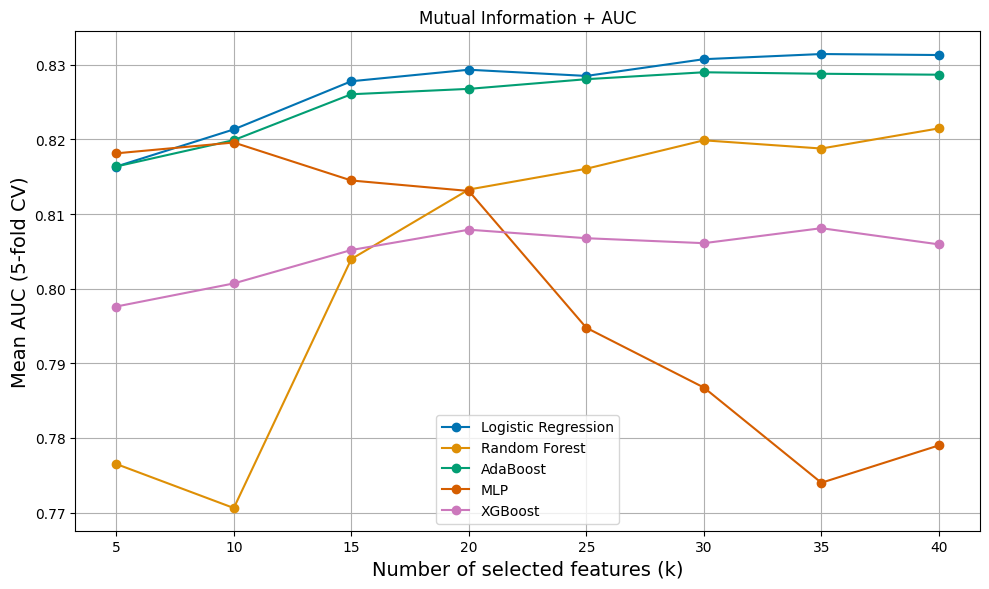

In [6]:
colors = sns.color_palette("colorblind", n_colors=len(results))

plt.figure(figsize=(10, 6))
for (model_name, aucs), color in zip(results.items(), colors):
    plt.plot(k_values, aucs, marker='o', label=model_name, color=color)

plt.xlabel("Number of selected features (k)")
plt.ylabel("Mean AUC (5-fold CV)")
plt.title("Mutual Information + AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_fig("Mutual Information + AUC")  
plt.show()

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
k = 20
# Select top 25 features using MI #  set up random seed for reproducibility #
selector = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k=k)
selector.fit(X_train_final, y_train_final)

# Get the column names of selected features
selected_features = X_train_final.columns[selector.get_support()].tolist()

# Filter X_train and X_test to only those features
X_train_final = X_train_final[selected_features]
X_test_final = X_test_final[selected_features]

print("Using these 20 features:", selected_features)

Using these 20 features: ['dem_age', 'provides_care', 'social_has_friends', 'has_longterm_illness', 'general_health_rating', 'health_limits_moderate_activity', 'health_limits_stairs', 'health_limits_daily_activities_amount', 'health_limits_work_type', 'health_pain_interferse_activity_type', 'social_general_trust', 'internet_shopping_freq', 'internet_video_streaming_freq', 'internet_music_streaming_freq', 'is_smoker', 'financial_situation_current', 'financial_situation_future', 'UCLA_loneliness_score', 'dem_ethnicity_White', 'household_size_3-4 people']


In [8]:
pd.Series(selected_features).to_csv(r"C:\Users\aleks\OneDrive - Coventry University\Desktop\selected_features_top20.csv", index=False)

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    print(f"Cross validation: {name}")
    aucs, f1s, precisions, recalls, briers, accuracies = [], [], [], [], [], []
    for train_idx, val_idx in cv.split(X_train_final, y_train_final):
        X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
        y_tr, y_val = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_proba))
        f1s.append(f1_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        accuracies.append(accuracy_score(y_val, y_pred))
        briers.append(brier_score_loss(y_val, y_proba))

    results.append({
        "Model": name,
        "AUC Mean": np.mean(aucs),
        "F1 Mean": np.mean(f1s),
        "Precision Mean": np.mean(precisions),
        "Recall Mean": np.mean(recalls),
        "Accuracy Mean": np.mean(accuracies),
        "Brier Score Mean": np.mean(briers),
    })

Cross validation: Logistic Regression
Cross validation: Random Forest
Cross validation: AdaBoost
Cross validation: MLP
Cross validation: XGBoost


In [10]:
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv(r"C:\Users\aleks\OneDrive - Coventry University\Desktop\Project_Data\'model_cv_results.csv", index=False)

                 Model  AUC Mean   F1 Mean  Precision Mean  Recall Mean  \
0  Logistic Regression  0.829261  0.492499        0.680741     0.386057   
1        Random Forest  0.818151  0.475171        0.669018     0.368930   
2             AdaBoost  0.828219  0.488690        0.662058     0.387720   
3                  MLP  0.801480  0.471635        0.617342     0.387476   
4              XGBoost  0.804606  0.476259        0.610613     0.390816   

   Accuracy Mean  Brier Score Mean  
0       0.836200          0.118917  
1       0.832427          0.121924  
2       0.833064          0.169380  
3       0.823069          0.130316  
4       0.822921          0.129716  


In [11]:
print(X_train_final.shape)
print(X_test_final.shape)
print(y_train_final.shape)
print(y_test_final.shape)

(20409, 20)
(5103, 20)
(20409,)
(5103,)


In [12]:
# X_train_raw, X_test_raw, y_train, y_test
joblib.dump(X_train_final, 'X_train_final_MI.joblib')
joblib.dump(X_test_final, 'X_test_final_MI.joblib')
joblib.dump(y_train_final, 'y_train_final_MI.joblib')
joblib.dump(y_test_final, 'y_test_final_MI.joblib')

['y_test_final_MI.joblib']